
**Date created: 28 March 2023**<br>
**Last modified:  27 April 2023**<br>

### Author: Hank Hoang

## Importing the necessary libraries and loading data

In [ ]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import seaborn as sns
%matplotlib inline

In [ ]:
#Reading the data
df = pd.read_csv('data_0.csv')

### Checking missing values

In [ ]:
df.isnull().values.any()

True

In [ ]:
df.isnull().sum()

DR_NO                0
Date Rptd            0
DATE OCC             0
TIME OCC             0
AREA                 0
AREA NAME            0
Rpt Dist No          0
Part 1-2             0
Crm Cd               0
Crm Cd Desc          0
Mocodes            591
Vict Age             0
Vict Sex           557
Vict Descent       557
Premis Cd            0
Premis Desc          0
Weapon Used Cd    3373
Weapon Desc       3373
Status               0
Status Desc          0
Crm Cd 1             0
Crm Cd 2          4683
Crm Cd 3          4997
Crm Cd 4          4999
LOCATION             0
Cross Street      3950
LAT                  0
LON                  0
dtype: int64

There are a lot of missing values in columns like Mocodes, Vict Sex, Vict Descent, Weapon Used Cd, Weapon Desc,Cross Street, Crm Cd 2,3,4

In [ ]:
#Looking at data
df.head()


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468


* Some observations showed that the reported date was later than the incident occurred to date. Therefore, I just selected the occurred incident date for model's prediction later.
* The Date Occ column has repeated 12:00:00 AM text, it's invaluable information, so I deleted it and combined it with the time column next to it for further time series model.

In [ ]:
df['DATE OCC'] = df['DATE OCC'].str.replace('12:00:00 AM', '')

In [ ]:
df['TIME OCC'] = df['TIME OCC'].apply(lambda x: '{0:0>4}'.format(x))
df['TIME OCC'] = pd.to_datetime(df['TIME OCC'], format='%H%M').dt.strftime('%H:%M')

In [ ]:
df.shape

(4022, 28)

In [ ]:
# Combine date and time into a single datetime column
df['datetime'] = pd.to_datetime(df['DATE OCC'] + ' ' + df['TIME OCC'])


* Refine the dataset by removing unnecessary columns ( DR_NO, Crm Cd 3, Crm Cd 4, Location and Cross Street) 
* Crm Cd 2, Crm Cd 3, Crm Cd 4,Cross Street contains blank cells
* Location attribute has a lot of incomplete information due to privacy reasons.

In [ ]:
# Refine the dataset by removing unnecessary columns ( DR_NO,Crm Cd 2, Crm Cd 3, Crm Cd 4)
df = df.drop(columns=['DR_NO','Crm Cd 1','Crm Cd 2','Crm Cd 3','Crm Cd 4','Date Rptd','Cross Street','LOCATION'])

In [ ]:
df.describe()

,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Premis Cd,Weapon Used Cd,Crm Cd 1,LAT,LON
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,1627.000000,5000.000000,5000.000000,5000.000000
mean,4.073000,455.251200,1.384000,501.036200,30.770600,287.606800,373.540258,500.750200,33.998340,-118.190827
std,3.796282,378.819536,0.486407,206.651939,21.512706,223.954334,116.441831,206.442457,0.967106,3.345331
min,1.000000,101.000000,1.000000,110.000000,-1.000000,101.000000,101.000000,110.000000,0.000000,-118.650300
25%,2.000000,212.000000,1.000000,331.000000,19.000000,101.000000,400.000000,331.000000,34.022000,-118.305825
50%,3.000000,361.000000,1.000000,442.000000,31.000000,122.000000,400.000000,442.000000,34.045900,-118.274350
75%,5.000000,509.000000,2.000000,626.000000,46.000000,501.000000,400.000000,626.000000,34.062400,-118.247400
max,21.000000,2189.000000,2.000000,956.000000,99.000000,968.000000,515.000000,956.000000,34.320800,0.000000


In [ ]:
df.corr()

<ipython-input-30-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Premis Cd,Weapon Used Cd,LAT,LON
AREA,1.000000,0.997576,-0.039824,-0.080863,0.043848,-0.000093,-0.022505,0.015444,-0.008850
Rpt Dist No,0.997576,1.000000,-0.040237,-0.082279,0.044749,-0.002955,-0.024032,0.013587,-0.007797
Part 1-2,-0.039824,-0.040237,1.000000,0.778289,0.139317,0.225831,0.368730,-0.016759,0.015802
Crm Cd,-0.080863,-0.082279,0.778289,1.000000,-0.038050,0.160562,0.297297,-0.030654,0.028516
Vict Age,0.043848,0.044749,0.139317,-0.038050,1.000000,0.079032,0.059019,0.006694,-0.005498
Premis Cd,-0.000093,-0.002955,0.225831,0.160562,0.079032,1.000000,0.209809,0.005823,-0.006714
Weapon Used Cd,-0.022505,-0.024032,0.368730,0.297297,0.059019,0.209809,1.000000,-0.027415,0.021191
LAT,0.015444,0.013587,-0.016759,-0.030654,0.006694,0.005823,-0.027415,1.000000,-0.998246
LON,-0.008850,-0.007797,0.015802,0.028516,-0.005498,-0.006714,0.021191,-0.998246,1.000000


In [ ]:
df.to_csv('data.csv', index=False)

## Exploratory data analysis

In [ ]:
# Importing libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

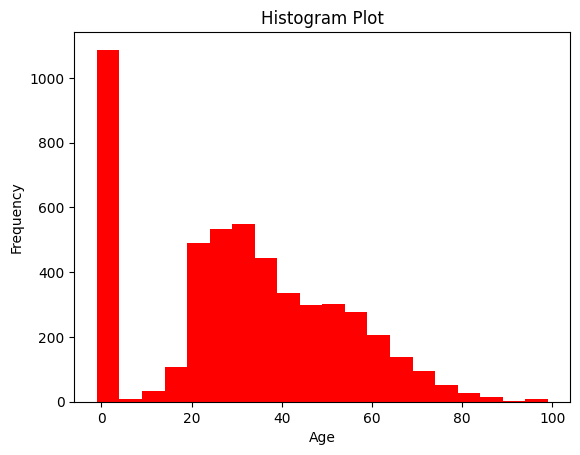

In [ ]:
# create a histogram plot with 20 bins
plt.hist(df['Vict Age'], bins=20, color= 'red')

# add title and labels
plt.title('Histogram Plot')
plt.xlabel('Age')
plt.ylabel('Frequency')

# show the plot
plt.show()

## Where happened the most illegal activities?

In [ ]:
premise=df['Premis Desc'].value_counts().nlargest(10)


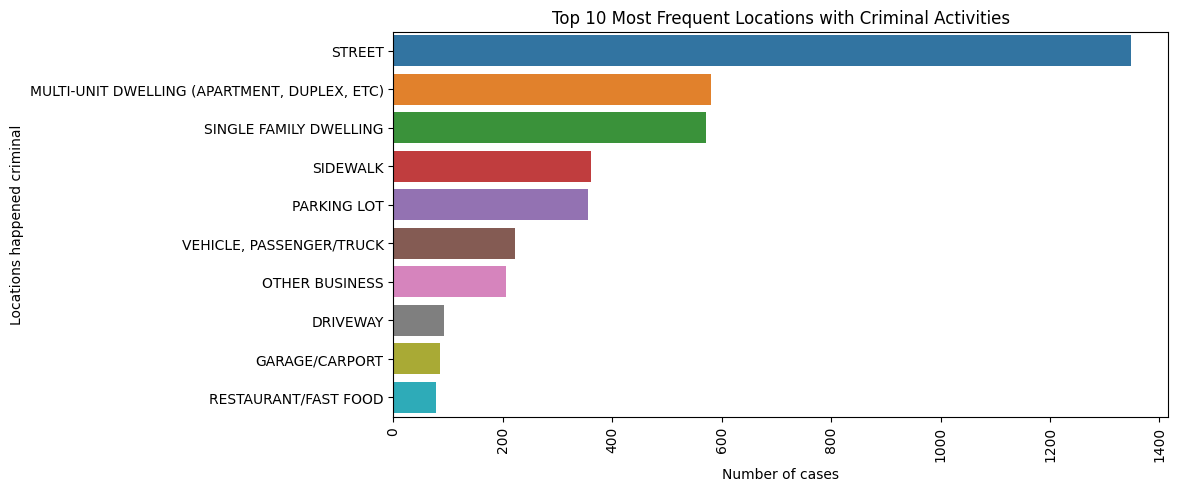

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=premise.values,y=premise.index)
plt.title('Top 10 Most Frequent Locations with Criminal Activities')
plt.xlabel('Number of cases')
plt.ylabel('Locations happened criminal')
plt.xticks(rotation=90)

plt.show()

Street is the most common location where criminal activities happened. Apartments and households are the other common targets of offenders.

## What time of day do criminal activities happen the most? 

In [ ]:
time=df['TIME OCC'].value_counts().nlargest(10)
time

12:00    164
20:00    159
19:00    148
18:00    132
17:00    124
15:00    123
22:00    123
21:00    108
16:00    107
13:00    100
Name: TIME OCC, dtype: int64

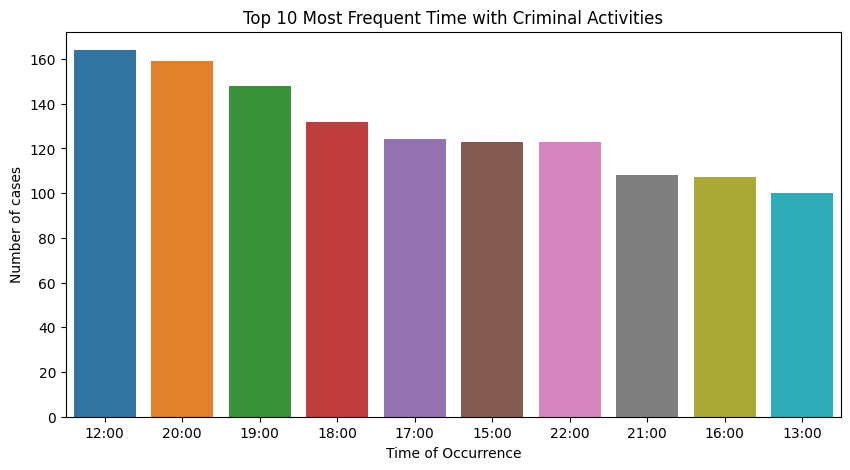

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=time.index, y=time.values)
plt.title('Top 10 Most Frequent Time with Criminal Activities')
plt.xlabel('Time of Occurrence')
plt.ylabel('Number of cases')
plt.show()

*Surprisingly, most criminal activities happened at noon.*

**What type of crime happened at that time?**

In [ ]:
subset_df = df.loc[df['TIME OCC'] == "12:00", :]
type_crim=subset_df['Crm Cd Desc'].value_counts().nlargest(3)

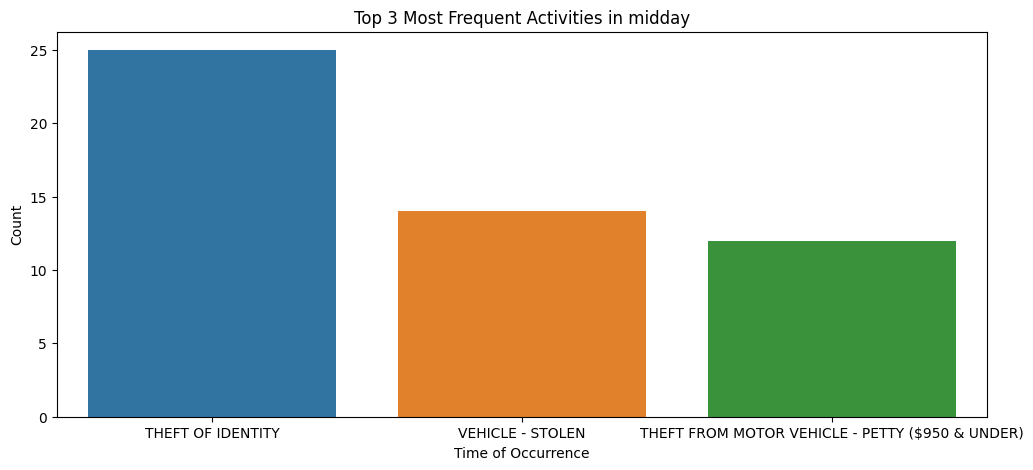

In [ ]:
plt.figure(figsize=(12,5))
sns.barplot(x=type_crim.index, y=type_crim.values)
plt.title('Top 3 Most Frequent Activities in midday')
plt.xlabel('Time of Occurrence')
plt.ylabel('Count')
plt.show()

Most of incidents in the midday were related to theft.

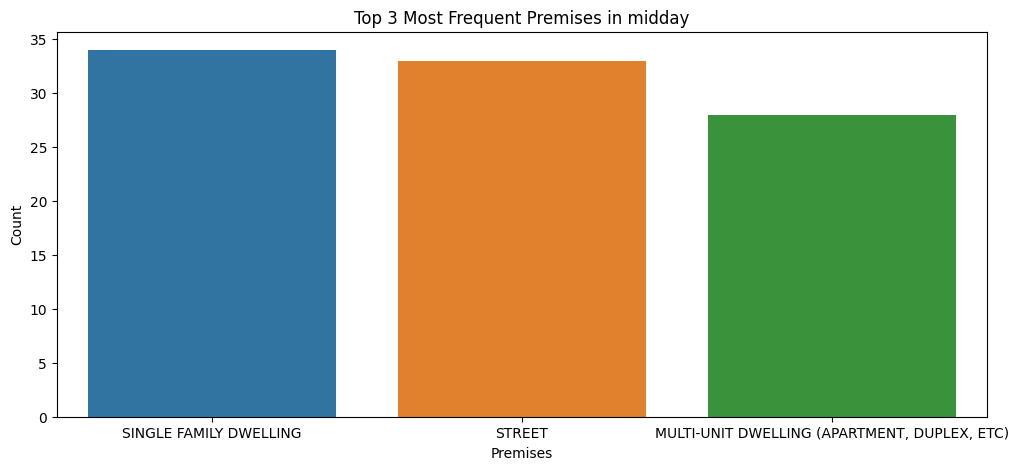

In [ ]:
premises = subset_df['Premis Desc'].value_counts().nlargest(3)
plt.figure(figsize=(12,5))
sns.barplot(x=type_crim.index, y=type_crim.values)
plt.title('Top 3 Most Frequent Premises in midday')
plt.xlabel('Premises')
plt.ylabel('Count')
plt.show()

Houses and streets are the most common places where incidents happened in the midday.

**Hypothesis:** midday is when people and police have less caution about criminals, and criminals tend to choose places where there's no sign of police.  

## Victim Descent

In [ ]:
mapping = {'A': 'Asian', 'B': 'Black', 'C': 'Chinese','F':'Filipino','H':'Hispanic/Latin/Mexican','I':'Indian', 'K':'Korean', 'O':'Others', 'V':'Vietnamese','W':'White','X':'Unknowns'}
df['Vict Descent'].map(mapping).value_counts()

Hispanic/Latin/Mexican    1693
White                      933
Black                      780
Unknowns                   525
Others                     300
Asian                      155
Chinese                     15
Filipino                    14
Korean                      14
Indian                      10
Vietnamese                   4
Name: Vict Descent, dtype: int64

* Because the number of Chinese, Filipino, Korean, Indian and Vietnamese are not significant and can group them into Asian group.


* Others and Unknowns cases can group together into one group.

In [ ]:
# Count the values
df1 = df['Vict Descent'].map(mapping).value_counts().reset_index()

# Rename the columns
df1.columns = ['Vict Descent', 'count']

In [ ]:
df1.loc[3, 'Vict Descent'] = 'Others'
df1.loc[6, 'Vict Descent'] = 'Asian'
df1.loc[7, 'Vict Descent'] = 'Asian'
df1.loc[8, 'Vict Descent'] = 'Asian'
df1.loc[9, 'Vict Descent'] = 'Asian'
df1.loc[10, 'Vict Descent'] = 'Asian'

In [ ]:
grouped=df1.groupby('Vict Descent').sum()

In [ ]:
grouped

,count
Vict Descent,
Asian,212
Black,780
Hispanic/Latin/Mexican,1693
Others,825
White,933


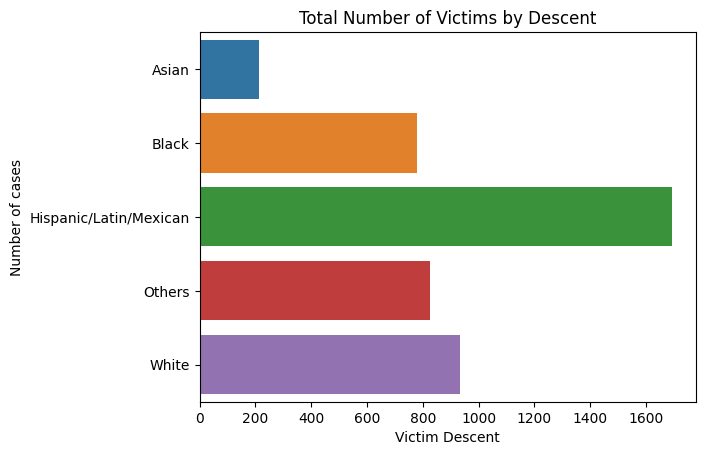

In [ ]:
grouped = df1.groupby('Vict Descent').sum().reset_index()

# Create barplot using Seaborn
sns.barplot(x='count', y='Vict Descent', data=grouped, orient='h')

# Add labels and title
plt.xlabel('Victim Descent')
plt.ylabel('Number of cases')
plt.title('Total Number of Victims by Descent')

# Show plot
plt.show()

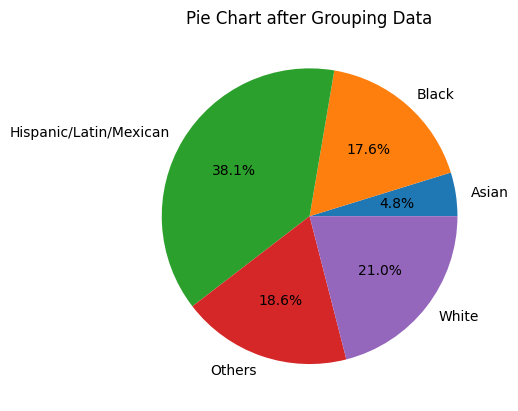

In [ ]:
# Create pie chart using Matplotlib
plt.pie(grouped['count'], labels=grouped['Vict Descent'], autopct='%1.1f%%')

# Add title
plt.title('Proportion of Victims Descent')
# Show plot
plt.show()

Hispanic/Latin/Mexican victims accounted for the highest percentage of victims at 38.1%, making them the most abundant ethnic group represented in the data. The next largest group of victims were White people, accounting for 21% of the victims.
The Black community accounted for 17.6% of victims, while the "Others" category accounted for 18.6%. The Asian community had the lowest number of victims, accounting for only 4.8% of the total.

## Sex of the victims

<Axes: xlabel='Vict Sex', ylabel='count'>

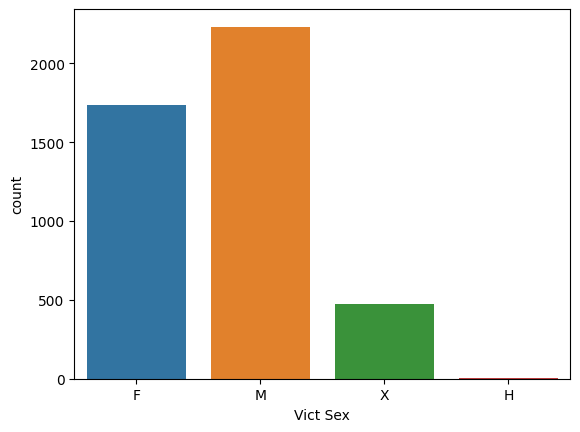

In [ ]:
sns.countplot(x='Vict Sex', data=df)


Male victims are more than female victims.

## Common types of crime

In [ ]:
df['Crm Cd Desc'].value_counts().nlargest(10)

VEHICLE - STOLEN                                           442
BATTERY - SIMPLE ASSAULT                                   439
BURGLARY FROM VEHICLE                                      396
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)        332
THEFT PLAIN - PETTY ($950 & UNDER)                         328
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    294
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)            244
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT             231
BURGLARY                                                   222
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                   198
Name: Crm Cd Desc, dtype: int64

In [ ]:
df['Weapon Desc'].value_counts()

STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)    909
UNKNOWN WEAPON/OTHER WEAPON                       193
VERBAL THREAT                                     120
HAND GUN                                           74
OTHER KNIFE                                        38
KNIFE WITH BLADE 6INCHES OR LESS                   29
UNKNOWN FIREARM                                    23
SEMI-AUTOMATIC PISTOL                              21
MACE/PEPPER SPRAY                                  19
BOTTLE                                             16
STICK                                              15
PIPE/METAL PIPE                                    13
ROCK/THROWN OBJECT                                 12
BLUNT INSTRUMENT                                   11
KNIFE WITH BLADE OVER 6 INCHES IN LENGTH           10
REVOLVER                                            9
AIR PISTOL/REVOLVER/RIFLE/BB GUN                    9
KITCHEN KNIFE                                       9
SIMULATED GUN               

In [ ]:
sns.barplot(x='Crime', y=top_crimes.values, hue='Weapon Type', data=df, palette=color_palette)


# Status of Criminal Cases

In [ ]:
status['Status Desc'].value_counts()

Invest Cont     3426
Adult Other      298
Adult Arrest     283
Juv Arrest        12
Juv Other          2
Name: Status Desc, dtype: int64

In [ ]:
status=df[['Crm Cd Desc','Status Desc']]

In [ ]:
subset_df = status[status['Status Desc'] == 'Adult Arrest']

In [ ]:
status[status['Status Desc'] == 'Juv Arrest']

,Crm Cd Desc,Status Desc
472,ROBBERY,Juv Arrest
540,SHOPLIFTING - PETTY THEFT ($950 & UNDER),Juv Arrest
1442,VANDALISM - MISDEAMEANOR ($399 OR UNDER),Juv Arrest
1444,ATTEMPTED ROBBERY,Juv Arrest
1536,"RAPE, FORCIBLE",Juv Arrest
1650,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",Juv Arrest
1673,BATTERY - SIMPLE ASSAULT,Juv Arrest
1674,BATTERY - SIMPLE ASSAULT,Juv Arrest
2862,ROBBERY,Juv Arrest
2986,KIDNAPPING,Juv Arrest


 A quick look through Juvenile crime activities.

In [ ]:
subset_df['Crm Cd Desc'].value_counts().nlargest(10)

ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT             50
INTIMATE PARTNER - SIMPLE ASSAULT                          26
ROBBERY                                                    24
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    21
INTIMATE PARTNER - AGGRAVATED ASSAULT                      20
BURGLARY                                                   19
CRIMINAL THREATS - NO WEAPON DISPLAYED                     15
BATTERY - SIMPLE ASSAULT                                   12
BRANDISH WEAPON                                             7
SEX OFFENDER REGISTRANT OUT OF COMPLIANCE                   6
Name: Crm Cd Desc, dtype: int64

In [ ]:
status[status['Crm Cd Desc'] == 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT']

,Crm Cd Desc,Status Desc
24,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",Adult Other
27,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",Adult Arrest
42,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",Adult Arrest
43,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",Adult Arrest
61,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",Invest Cont
...,...,...
3917,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",Invest Cont
3980,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",Invest Cont
3981,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",Invest Cont
4010,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",Adult Arrest


There is an inconsistency between Criminal description and Status Description, that means deciding to arrest an adult or continue investigations depends on each specific case.